<a href="https://colab.research.google.com/github/rhiats/pimaSpec/blob/main/pima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score
!pip install shap
import shap

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load Data**

There are 768 people included in the dataset with 10 columns in the dataset. There is a unique identification number of each person in the dataset and a outcome for the person as either Diabetic or Healthy. The others are potential features: 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness','Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age.'

In [3]:
df=pd.read_csv("/content/drive/MyDrive/assignments/Fall24/Spec/diabetes.csv")
df.insert(0, 'ID', range(0, len(df)))
df.head()
df.astype(int)
df['Outcome'] = np.where(df['Outcome']==0, 'Healthy', 'Diabetic')
print(df.shape)

(768, 10)


In [4]:
df.columns

Index(['ID', 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

**Check for Missing Values**

There are no missing values in the dataset, so no need to impute any values.

https://tarupublication.s3.ap-south-1.amazonaws.com/articles/jsms-1253.pdf

In [5]:
missing_count = df.isnull().sum()

In [6]:
missing_count.rename("Number of Missing Values")

,Number of Missing Values
ID,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


**Class Balance**

The data is imbalanced with 35% Diabetic and 65% healthy. This is to be expected with health data and there is usually more health people than unhealthy people. It is not important to understand how this imbalance should be handled moving down stream. Potentially there could be undersampling of the majority class or oversampling of the minorty class.

    Outcome  Relative Frequency (%)
0  Diabetic               34.895833
1   Healthy               65.104167


<ipython-input-7-07609e37ed80>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ratio_df, x='Outcome', y="Relative Frequency (%)", palette="pastel")
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


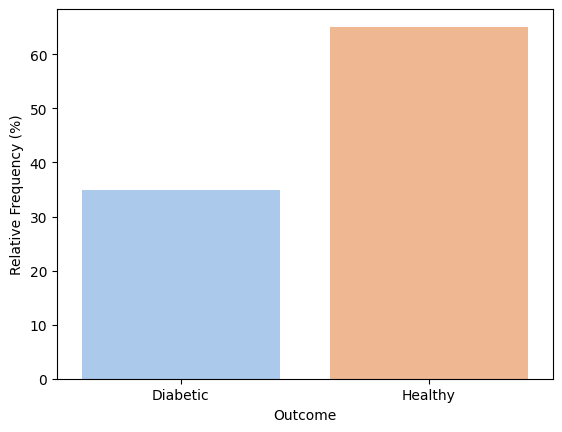

In [7]:
def balanced(df):
  """
    Percentage of people with Diabetes and those without Diabetes
    Balanced or Imbalanced Data

    @p:
      df (dataframe): Input dataframe
  """

  ratio_df=(df[['ID','Outcome']].groupby('Outcome').count()/df.shape[0])*100

  ratio_df.reset_index(inplace=True)

  ratio_df.rename(columns={"ID": "Relative Frequency (%)"}, inplace=True)

  print(ratio_df)

  sns.barplot(data=ratio_df, x='Outcome', y="Relative Frequency (%)", palette="pastel")

  plt.savefig("/content/drive/MyDrive/assignments/Fall24/Spec/output/balanced.png")

balanced(df)

**Conditional Probability**

- Liklihood Someone is has diabetes given they are Overweight (BMI >=25)
- Probability a person is Diabetic Given that she had at least 3 pregnancies

https://www.ramsayhealth.co.uk/weight-loss-surgery/bmi/bmi-for-women

In [8]:
Overweight_and_diabetic_df=df[(df['Outcome']=='Diabetic') & (df['BMI']>=25)]
Overweight_df=df[(df['BMI']>=25)]
prob_diabetic_given_overweight=round((Overweight_and_diabetic_df.shape[0]/Overweight_df.shape[0])*100)
'The probability a person develops Diabetes given she is overweight is {}%'.format(prob_diabetic_given_overweight)

'The probability a person develops Diabetes given she is overweight is 40%'

In [9]:
Preg_and_diabetic_df=df[(df['Outcome']=='Diabetic') & (df['Pregnancies']>=3)]
Preg_df=df[(df['Pregnancies']>=3)]
prob_diabetic_given_preg3=round((Preg_and_diabetic_df.shape[0]/Preg_df.shape[0])*100)
'The probability a person develops Diabetes given she has at least 3 pregnancies is {}%'.format(prob_diabetic_given_preg3)

'The probability a person develops Diabetes given she has at least 3 pregnancies is 43%'

**Distributions**

Histogram plot
*   It is possible to have 0 glucose reading
*   It is not possible to have a blood pressure of 0
*   0 rating on a skin thickness scale indicates normal skin thickness
*   A BMI of 0 is possible and indicates that a person's weight is in line with their height

Need to decide what to do with 0 glucose reading






,Insulin
count,768.000000
mean,79.799479
std,115.244002
min,0.000000
25%,0.000000
50%,30.500000
75%,127.250000
max,846.000000


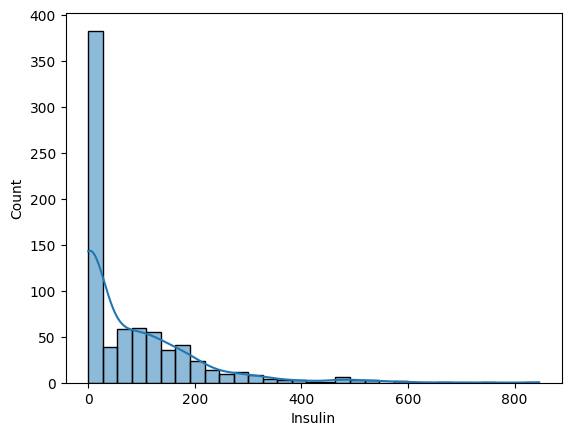

In [10]:
sns.histplot(data=df, x="Insulin",kde=True)
plt.savefig("/content/drive/MyDrive/assignments/Fall24/Spec/output/insulin_distribution.png")
df.Insulin.describe()

,Glucose
count,768.000000
mean,120.894531
std,31.972618
min,0.000000
25%,99.000000
50%,117.000000
75%,140.250000
max,199.000000


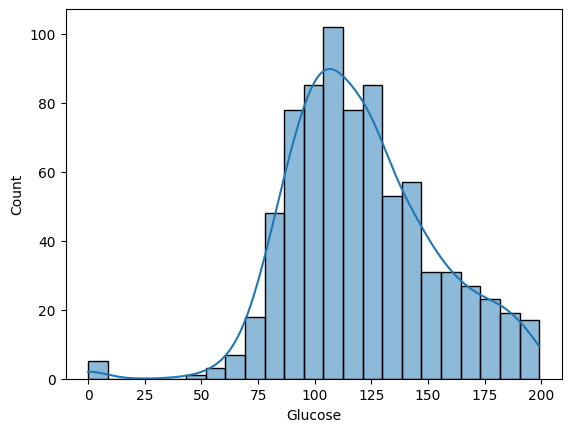

In [11]:
sns.histplot(data=df, x="Glucose",kde=True)
plt.savefig("/content/drive/MyDrive/assignments/Fall24/Spec/output/glucose_distribution.png")
df.Glucose.describe()

,SkinThickness
count,768.000000
mean,20.536458
std,15.952218
min,0.000000
25%,0.000000
50%,23.000000
75%,32.000000
max,99.000000


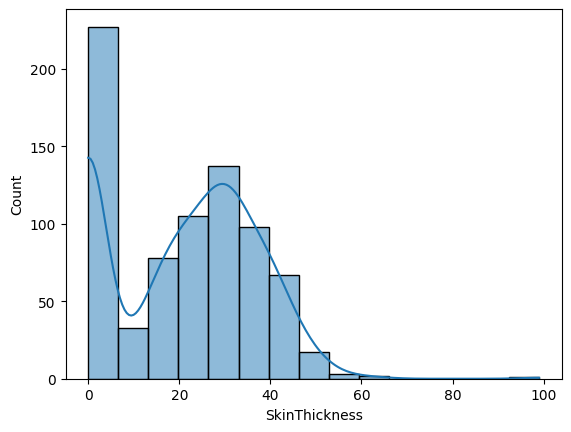

In [12]:
sns.histplot(data=df, x="SkinThickness",kde=True)
plt.savefig("/content/drive/MyDrive/assignments/Fall24/Spec/output/SkinThickness_distribution.png")
df.SkinThickness.describe()

In [13]:
df.describe()

,ID,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,383.500000,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,221.846794,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,191.750000,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,383.500000,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,575.250000,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,767.000000,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


**Number of Glucose value is 0**

In [14]:
glucose_count_under0 = df[(df['Glucose'] == 0)].shape[0]

print("There are {} females missing glucose data".format(glucose_count_under0))

There are 5 females missing glucose data


In [15]:
df_glucose_under_0_id=df[(df['Glucose'] == 0)][['ID','Glucose']]
df_glucose_under_0_id

,ID,Glucose
75,75,0
182,182,0
342,342,0
349,349,0
502,502,0


**Number of Blood Pressure that is 0**

In [16]:
blood_pressure0 = df[(df['BloodPressure'] == 0)].shape[0]
percent_missing_bp=round((blood_pressure0/df['ID'].nunique())*100,0)

print("There are {} females missing Blood Pressure data, which is {}% of the dataset".format(blood_pressure0,percent_missing_bp))

There are 35 females missing Blood Pressure data, which is 5.0% of the dataset


In [17]:
blood_pressure0_df=df[(df['BloodPressure'] == 0)][['ID','BloodPressure']]
blood_pressure0_df

,ID,BloodPressure
7,7,0
15,15,0
49,49,0
60,60,0
78,78,0
81,81,0
172,172,0
193,193,0
222,222,0
261,261,0


**K-Means Cluster Patients**

K-Means cluster patients to identify the similar characteristics of the patients and impute the average glucose/bp values of the cluster for the missing glucose and BP values. Within-Cluster Sum of Squares (WCSS) is used to measure the fit of the datapoints to the cluster. The feeatures are standardized to prevent distortion of scale (i.e. age compared to insulin level).

Troyanskaya, O., Cantor, M., Sherlock, G., Brown, P., Hastie, T., Tibshirani, R., Botstein, D., & Altman, R. B. (2001). Missing value estimation methods for DNA microarrays. Bioinformatics (Oxford, England), 17(6), 520–525. https://doi.org/10.1093/bioinformatics/17.6.520

In [18]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X=df[["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age","Outcome"]]
X['Outcome'] = df['Outcome'].apply(lambda x: 1 if x=='Diabetic' else 0)

<ipython-input-18-8bf7dbef3d32>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Outcome'] = df['Outcome'].apply(lambda x: 1 if x=='Diabetic' else 0)


In [19]:
# Elbow method to determine the optimal number of clusters
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
<ipython-input-20-40e07a4eabfd>:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=50, cmap='viridis')


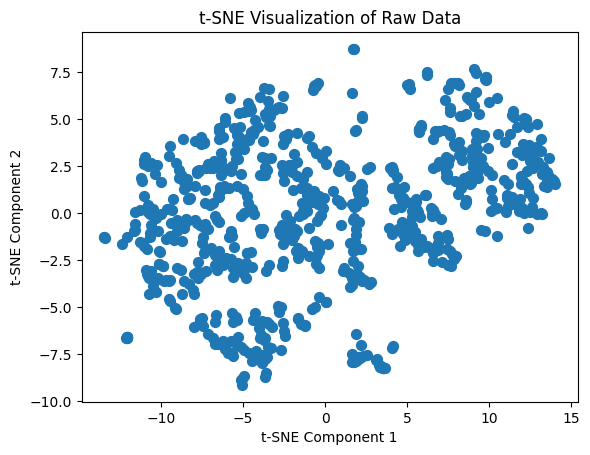

In [20]:
#t-SNE (t-distributed Stochastic Neighbor Embedding) to vizualize the cluster
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42) #Reduce 9 dimensions to 2
X_tsne = tsne.fit_transform(X_scaled)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=50, cmap='viridis')
plt.title('t-SNE Visualization of Raw Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

<ipython-input-21-c7e41b31e520>:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca[:, 0], X_pca[:, 1], s=50, cmap='viridis', alpha=0.7)


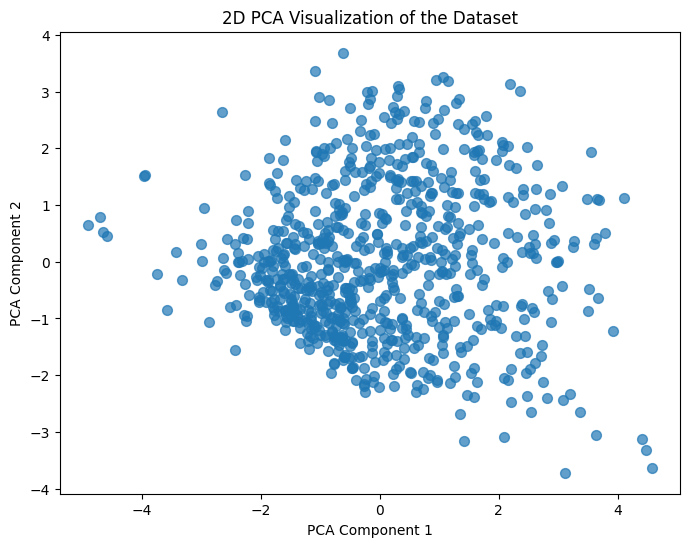

In [21]:
#pca visualization of the datapoints

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=50, cmap='viridis', alpha=0.7)
plt.title('2D PCA Visualization of the Dataset')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.savefig("/content/drive/MyDrive/assignments/Fall24/Spec/output/pca_raw_data.png")
plt.show()

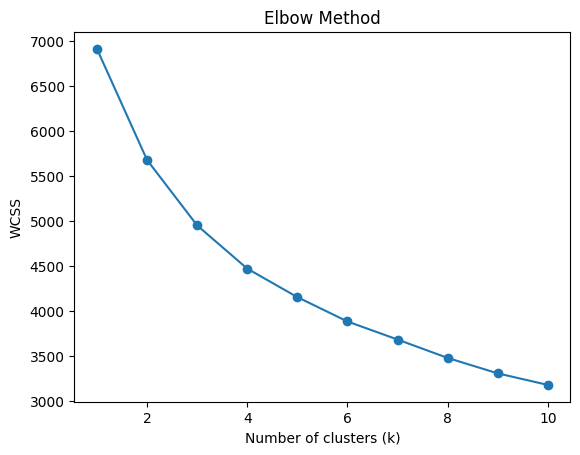

In [22]:
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.savefig("/content/drive/MyDrive/assignments/Fall24/Spec/output/k_means_elbow.png")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


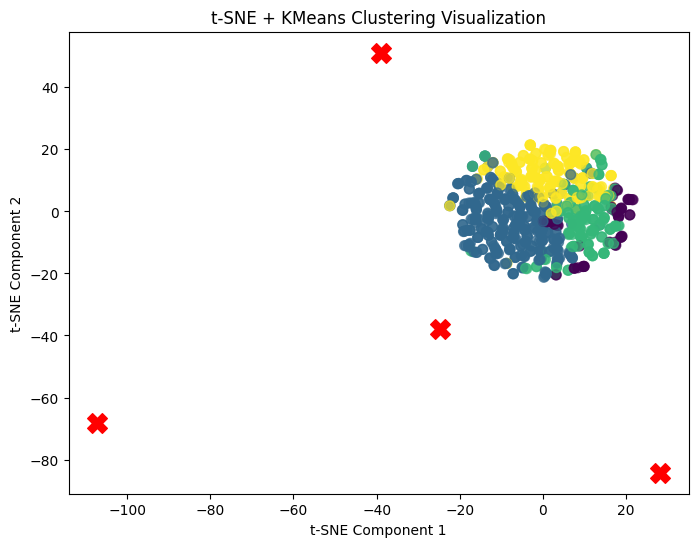

In [23]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_scaled)

centers = kmeans.cluster_centers_
labels = kmeans.labels_

tsne = TSNE(n_components=2, perplexity=2, n_iter=300, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

cluster_centers = kmeans.cluster_centers_
cluster_centers_tsne = tsne.fit_transform(cluster_centers)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7, label='Data Points')
plt.scatter(cluster_centers_tsne[:, 0], cluster_centers_tsne[:, 1], c='red', s=200, marker='X', label='Cluster Centers')

plt.title('t-SNE + KMeans Clustering Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

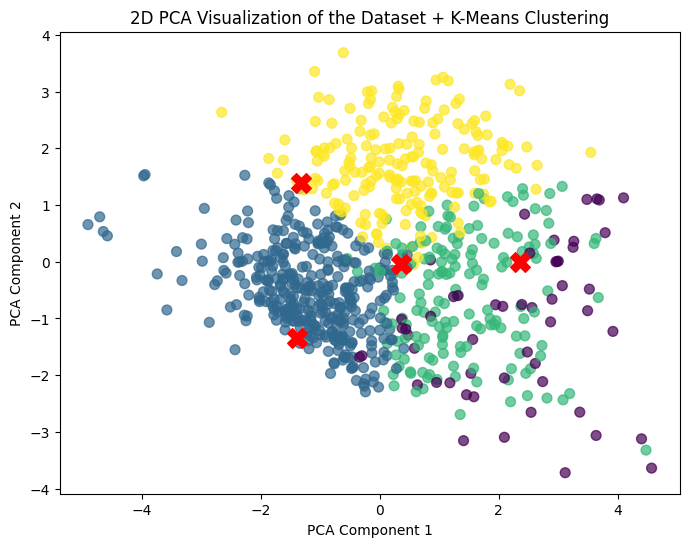

In [24]:
#pca visualization with cluster centers
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
cluster_centers_pca = pca.fit_transform(cluster_centers)

# Step 2: Plot the PCA result in 2D
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=50, c=labels, cmap='viridis', alpha=0.7)
plt.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1], c='red', s=200, marker='X', label='Cluster Centers')
plt.title('2D PCA Visualization of the Dataset + K-Means Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.savefig("/content/drive/MyDrive/assignments/Fall24/Spec/output/pca_clustered_data_centers.png")
plt.show()

In [25]:
#Patient Identifaction
#Compute median values of Glucose and BP
#Impute values

df_glucose_under_0_id_lst=df[(df['Glucose'] == 0)][['ID','Glucose']]['ID'].tolist()
blood_pressure0_lst=df[(df['BloodPressure'] == 0)][['ID','BloodPressure']]['ID'].tolist()

df["cluster_id"]=labels

df_no_glucose_missing_df=df[~df['ID'].isin(df_glucose_under_0_id_lst)][["cluster_id","Glucose"]]
df_no_bp_missing_df=df[~df['ID'].isin(blood_pressure0_lst)][["cluster_id","BloodPressure"]]

glucose_median_df=df_no_glucose_missing_df.groupby("cluster_id").median("Glucose").reset_index()
glucose_median_df = glucose_median_df.rename(columns={'Glucose': 'Glucose_Med'})

bp_median_df=df_no_bp_missing_df.groupby("cluster_id").median("BloodPressure").reset_index()
bp_median_df = bp_median_df.rename(columns={'BloodPressure': 'BloodPressure_Med'})

#Glucose replace with median
df_missing_glucose=df[df['ID'].isin(df_glucose_under_0_id_lst)][["ID","cluster_id","Glucose"]]
df_missing_glucose_med=pd.merge(df_missing_glucose,glucose_median_df,how='inner',on='cluster_id')
df=pd.merge(df_missing_glucose_med,df,how='right',on='ID')
df=df[['ID','Glucose_Med','Pregnancies','Glucose_y','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age','Outcome','cluster_id_y']]
df['Glucose_Med'] = df['Glucose_Med'].fillna(df['Glucose_y'])

df=df.rename(columns={"Glucose_Med":"Glucose","cluster_id_y":"cluster_id"})
df.drop(inplace=True,labels=['Glucose_y'],axis=1)

#Blood Pressure replace with median
df_missing_bp=df[df['ID'].isin(blood_pressure0_lst)][["ID","cluster_id","BloodPressure"]]
df_missing_bp_med=pd.merge(df_missing_bp,bp_median_df,how='inner',on='cluster_id')
df=pd.merge(df_missing_bp_med,df,how='right',on='ID')
df=df[['ID','BloodPressure_Med','Pregnancies','BloodPressure_y','Glucose','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age','Outcome']]
df['BloodPressure_Med'] = df['BloodPressure_Med'].fillna(df['BloodPressure_y'])

df=df.rename(columns={"BloodPressure_Med":"BloodPressure","cluster_id_y":"cluster_id"})
df.drop(inplace=True,labels=['BloodPressure_y'],axis=1)

df.describe()

,ID,BloodPressure,Pregnancies,Glucose,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,383.500000,72.298177,3.845052,121.608073,20.536458,79.799479,31.992578,0.471876,33.240885
std,221.846794,12.129286,3.369578,30.470133,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,24.000000,0.000000,44.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,191.750000,64.000000,1.000000,99.750000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,383.500000,72.000000,3.000000,117.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,575.250000,80.000000,6.000000,140.250000,32.000000,127.250000,36.600000,0.626250,41.000000
max,767.000000,122.000000,17.000000,199.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [26]:
df.head()

,ID,BloodPressure,Pregnancies,Glucose,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,72.0,6,148.0,35,0,33.6,0.627,50,Diabetic
1,1,66.0,1,85.0,29,0,26.6,0.351,31,Healthy
2,2,64.0,8,183.0,0,0,23.3,0.672,32,Diabetic
3,3,66.0,1,89.0,23,94,28.1,0.167,21,Healthy
4,4,40.0,0,137.0,35,168,43.1,2.288,33,Diabetic


**T-Test**

Is the Median/Average Age of a woman who is Diabetic significantly different from the age of a woman who is not Diabetic?

In [27]:

def t_test_survival(df):
  """
    Is the Median/Average Age of a woman who is Diabetic significantly
    different from the age of a woman who is not Diabetic?

    https://www.datacamp.com/tutorial/an-introduction-to-python-t-tests?utm_source=google&utm_medium=paid_search&utm_campaignid=19589720830&utm_adgroupid=143216588377&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=661628555645&utm_targetid=dsa-1947282172981&utm_loc_interest_ms=&utm_loc_physical_ms=9004416&utm_content=dsa~page~community-tuto&utm_campaign=230119_1-sea~dsa~tutorials_2-b2c_3-us_4-prc_5-na_6-na_7-le_8-pdsh-go_9-na_10-na_11-na&gclid=CjwKCAjwivemBhBhEiwAJxNWNyNhPMWI2_jEAUejU7VXHpPFlhbQYhS5W2wSmKHL-KiPZUM-DzKitBoCqS8QAvD_BwE

  """

  df_diab=df[df['Outcome']=='Diabetic']

  df_healthy=df[df['Outcome']=='Healthy']

  N1, N2 = df_diab.shape[0], df_healthy.shape[0]

  # Degrees of freedom
  dof = min(N1,N2) - 1
  print(dof)

  # Gaussian distributed data with mean of fare who died and var = 1
  x = np.random.randn(N1) + df_diab["Age"]

  # Gaussian distributed data with mean of fare who survived and var = 1
  y = np.random.randn(N2) + df_healthy["Age"]

  ## Using the internal function from SciPy Package
  t_stat, p_val = stats.ttest_ind(x, y, equal_var = False)
  print("t-statistic = " + str(t_stat))
  print("p-value = " + str(p_val))

t_test_survival(df)

267
t-statistic = 6.937746109744761
p-value = 1.0788014844011907e-11


In [28]:
diab_age=df[df['Outcome']=='Diabetic']['Age']
diab_age.describe()

,Age
count,268.000000
mean,37.067164
std,10.968254
min,21.000000
25%,28.000000
50%,36.000000
75%,44.000000
max,70.000000


In [29]:
healthy_age=df[df['Outcome']=='Healthy']['Age']
healthy_age.describe()

,Age
count,500.000000
mean,31.190000
std,11.667655
min,21.000000
25%,23.000000
50%,27.000000
75%,37.000000
max,81.000000


**PCA**

Based on the loadings the top three important features are Insulin, Glucose, and SkinThickness to predict the likelihood of Diabetes. The first component explains 94% of the variance in the data.

It may be beneficial to normalize the data to minimize the influence of any outliers on the analysis.

Reference:

https://www.datacamp.com/tutorial/principal-component-analysis-in-python

https://scentellegher.github.io/machine-learning/2020/01/27/pca-loadings-sklearn.html

https://stats.stackexchange.com/questions/27300/using-principal-component-analysis-pca-for-feature-selection

In [30]:
pca = PCA(n_components=2)
X=df.to_numpy()
X=X[:,1:-1]
X = pca.fit_transform(X)

In [31]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.90685182 0.05745327]


In [32]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1','PC2'], index=df.columns[1:-1])
loadings.sort_values(by=['PC1'], ascending=False)

,PC1,PC2
Insulin,0.993707,-0.086895
Glucose,0.092854,0.972316
SkinThickness,0.060817,-0.058460
BMI,0.013961,0.050945
DiabetesPedigreeFunction,0.000537,0.000861
Pregnancies,-0.002048,0.023956
BloodPressure,-0.003630,0.134196
Age,-0.003706,0.149847


**Project Instances for Visualization**

In [33]:
principalComponents_arr = pca.fit_transform(X)
principalComponents_df= pd.DataFrame(principalComponents_arr, columns = ['PC1','PC2'])

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/assignments/Fall24/Spec Project/output/pca.png'

<Figure size 640x480 with 0 Axes>

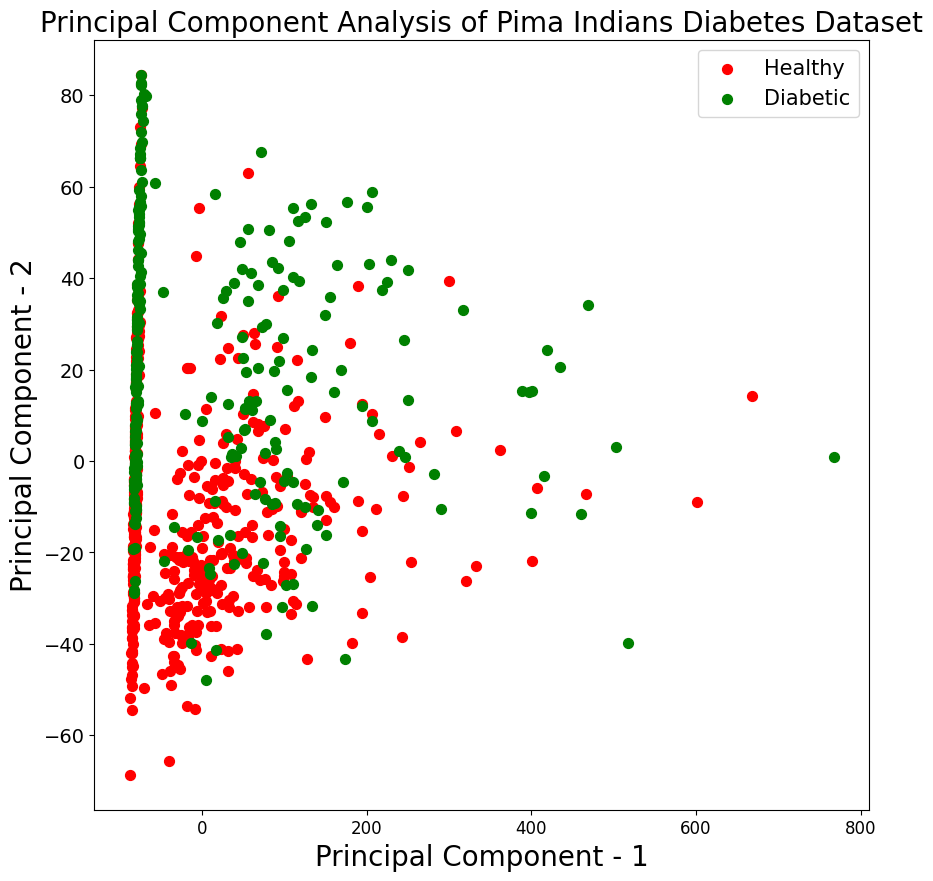

In [34]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Pima Indians Diabetes Dataset",fontsize=20)
targets = ['Healthy', 'Diabetic']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    df_target=df[df['Outcome'] == target]
    indicesToKeep=df_target.index
    plt.scatter(principalComponents_df.loc[indicesToKeep, 'PC1'] , principalComponents_df.loc[indicesToKeep, 'PC2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})

In [35]:
plt.savefig("/content/drive/MyDrive/assignments/Fall24/Spec/output/pca.png")

<Figure size 640x480 with 0 Axes>